In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
from moviepy.editor import VideoFileClip
from IPython.display import HTML
from pathlib import Path
import pickle
import math
global count
global left_fit
global right_fit

%matplotlib inline

##### Camera Calibration and distortion correction. 
Using a 9x5 chessboard and 20 calibration images

In [2]:


def CalibrateCamera(numCorners):
    images = glob.glob('camera_cal/calibration*.jpg')
    # real undistorted corners. known object vorrdinates. (x,y,z)
    objpoints = []
    # these are the corners
    imgpoints = []
    objp = np.zeros((numCorners[0]*numCorners[1], 3), np.float32)
    objp[:,:2] = np.mgrid[0:numCorners[0], 0:numCorners[1]].T.reshape(-1,2)
    for path in images:
        calibrationImage = mpimg.imread(path)    
        gray = cv2.cvtColor(calibrationImage,cv2.COLOR_RGB2GRAY)
        ret, corners = cv2.findChessboardCorners(gray, (numCorners[0],numCorners[1]),None)
        if ret == True:
            imgpoints.append(corners)
            objpoints.append(objp)
    
    # img = cv2.drawChessboardCorners(gray, (numCorners[0],numCorners[1]), corners, ret)
    print("Calibrating")
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1],None,None)
    dist_pickle = {}
    dist_pickle["mtx"] = mtx
    dist_pickle["dist"] = dist
    pickle.dump(dist_pickle, open("./calibration_pickle.p", "wb"))
    # need to open the pickel data instead of calibrating the camera
    return mtx, dist

           





Now the camera is calibrated, we need to undistort the image

In [3]:
def Undistort(image, mtx, dist ):
    return cv2.undistort(image, mtx, dist, None, mtx)


##### Perspective Transform
Need to turn the image into a top down view.
This will show the angle of the curve much better than a POV image


In [4]:
def GetWarpImageData_X(img_size):
    src = np.float32([[585, 460], 
                      [203, 720],
                      [1127, 720],
                      [695, 460]
                     ])
    dst = np.float32([[320, 0], [320, 720], [960, 720],[960, 0]])
    m = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    return m, Minv



In [5]:
def GetWarpImageData(img_size):
    botWidth = .76
    midWidth = .08
    heightPct = .62
    bottomTrim = .935
    offset = img_size[0]*.15
    src = np.float32([[img_size[0]*(.5-midWidth/2), img_size[1]*heightPct],
                      [img_size[0]*(.5+midWidth/2), img_size[1]*heightPct],
                      [img_size[0]*(.5-botWidth/2), img_size[1]*bottomTrim],
                      [img_size[0]*(.5+botWidth/2), img_size[1]*bottomTrim]])
   
    dst = np.float32([[offset, 0],
                      [img_size[0]-offset,0],
                      [offset, img_size[1]], 
                      [img_size[0]-offset, img_size[1]]])    
    # print("src:", src)
    # print("dst:", dst)    
    #dst = np.float32([[320, 0], [320, 720], [960, 720],[960, 0]])
    m = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    return m, Minv


##### Color and Gradient Threshold

Find the absolute gradiant, gradient direction and combine into one image



In [6]:
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Calculate directional gradient
    if orient == 'x':
        sobel = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    else:
        sobel = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    absSobel = np.absolute(sobel)
    scaledSobel = np.uint8(255*absSobel/np.max(absSobel))
    sxBinary = np.zeros_like(scaledSobel)
    sxBinary[(scaledSobel >= thresh[0]) & (scaledSobel <= thresh[1])] = 1   
    return sxBinary

In [7]:
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Apply the following steps to img
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Take the absolute value of the x and y gradients
    absSobelX = np.absolute(sobelx)
    absSobelY = np.absolute(sobely)
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient
    gradDir = np.arctan2(absSobelY, absSobelX)
    # 5) Create a binary mask where direction thresholds are met
    sxBinary = np.zeros_like(gradDir)
    sxBinary[(gradDir > thresh[0]) & (gradDir <= thresh[1])]=1
    # 6) Return this mask as your binary_output image
    return sxBinary


In [8]:
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Apply the following steps to img
    # 1) Convert to grayscale
    # gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Calculate the magnitude 
    absMag = np.sqrt(sobelx**2 + sobely**2)
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    #scaledSobel = np.uint8(255*absMag/np.max(absMag))
    scale_factor = np.max(absMag)/255 
    absMag = (absMag/scale_factor).astype(np.uint8) 
    # 5) Create a binary mask where mag thresholds are met
    #sxBinary = np.zeros_like(scaledSobel)
    #sxBinary[(scaledSobel >= mag_thresh[0]) & (scaledSobel <= mag_thresh[0])] = 1
    binary_output = np.zeros_like(absMag)
    binary_output[(absMag >= mag_thresh[0]) & (absMag <= mag_thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    return binary_output

In [9]:
# Pipeline for color and gradient work

def ProcessImage(img):
    """
    ksize=31
    min_gradx=24
    max_gradx=188
    min_grady=20
    max_grady=255
    min_mag=6
    max_mag=170
    min_dir=0 
    max_dir=1.0 
    gradx=abs_sobel_thresh(img, orient='x', sobel_kernel=ksize, thresh=(min_gradx, max_gradx))
    #grady=abs_sobel_thresh(image, orient='y', sobel_kernel=ksize, thresh=(min_grady, max_grady))
    mag_binary = mag_thresh(img, sobel_kernel=ksize, mag_thresh=(min_mag, max_mag))
    dir_binary = dir_threshold(img, sobel_kernel=ksize, thresh=(min_dir, max_dir))
    combined = np.zeros_like(dir_binary)
    combined[(gradx == 1) & ((mag_binary == 1) & (dir_binary == 1))] = 1
    """
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)    
    gradx = abs_sobel_thresh(gray, orient='x', sobel_kernel=3, thresh=(12, 255))
    grady = abs_sobel_thresh(gray, orient='y', sobel_kernel=3, thresh=(25, 255))
    c_binary = color_threshold(img, sThresh=(50,255), vThresh=(100,255) )
    finalImage = np.zeros_like(img[:,:,0])
    finalImage[((gradx ==1) & (grady == 1) | (c_binary == 1))] = 255
    #plt.imshow(finalImage, cmap="gray")
    return finalImage
    
def color_threshold(imagein, sThresh, vThresh ):
    
    hls = cv2.cvtColor(imagein, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= sThresh[0]) & (s_channel <= sThresh[1] )] =1
    
    hsv = cv2.cvtColor(imagein, cv2.COLOR_RGB2HSV)
    v_channel = hsv[:,:,2]
    v_binary = np.zeros_like(v_channel)
    v_binary[(v_channel >= vThresh[0]) &(v_channel <= vThresh[1] )] = 1
    
    output = np.zeros_like(s_channel)
    output[(s_binary ==1) & (v_binary == 1)] = 1
    return output
    



Once the image is warped, then we need to find the curvature of the lines


In [10]:
def window_mask(width, height, img_ref, center,level):
    output = np.zeros_like(img_ref)
    output[int(img_ref.shape[0]-(level+1)*height):int(img_ref.shape[0]-level*height),max(0,int(center-width/2)):min(int(center+width/2),img_ref.shape[1])] = 1
    return output


window_width = 25 
window_height = 120 # Break image into 9 vertical layers since image height is 720
margin = 100 # How much to slide left and right for searching


def find_window_centroids(image, window_width, window_height, margin):
    
    window_centroids = [] # Store the (left,right) window centroid positions per level
    window = np.ones(window_width) # Create our window template that we will use for convolutions
    warped = image
    # First find the two starting positions for the left and right lane by using np.sum to get the vertical image slice
    # and then np.convolve the vertical image slice with the window template 
    
    # Sum quarter bottom of image to get slice, could use a different ratio
    l_sum = np.sum(warped[int(3*warped.shape[0]/4):,:int(warped.shape[1]/2)], axis=0)
    l_center = np.argmax(np.convolve(window,l_sum))-window_width/2
    r_sum = np.sum(warped[int(3*warped.shape[0]/4):,int(warped.shape[1]/2):], axis=0)
    r_center = np.argmax(np.convolve(window,r_sum))-window_width/2+int(warped.shape[1]/2)
    
    # Add what we found for the first layer
    window_centroids.append((l_center,r_center))
    
    # Go through each layer looking for max pixel locations
    for level in range(1,(int)(warped.shape[0]/window_height)):
        # convolve the window into the vertical slice of the image
        image_layer = np.sum(warped[int(warped.shape[0]-(level+1)*window_height):int(warped.shape[0]-level*window_height),:], axis=0)
        conv_signal = np.convolve(window, image_layer)
        # Find the best left centroid by using past left center as a reference
        # Use window_width/2 as offset because convolution signal reference is at right side of window, not center of window
        offset = window_width/2
        l_min_index = int(max(l_center+offset-margin,0))
        l_max_index = int(min(l_center+offset+margin,warped.shape[1]))
        l_center = np.argmax(conv_signal[l_min_index:l_max_index])+l_min_index-offset
        # Find the best right centroid by using past right center as a reference
        r_min_index = int(max(r_center+offset-margin,0))
        r_max_index = int(min(r_center+offset+margin,warped.shape[1]))
        r_center = np.argmax(conv_signal[r_min_index:r_max_index])+r_min_index-offset
        # Add what we found for that layer
        window_centroids.append((l_center,r_center))

    return window_centroids


Once we have the lanes identified, we need to measure the curvature

##### Determine the curve of the road

In [11]:
def DetermineCurve(yvals, res_yvals, leftx, rightx):
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension 

    left_curve_fit_cr = np.polyfit(np.array(res_yvals, np.float32)*ym_per_pix, np.array(leftx, np.float32)* xm_per_pix, 2)
    left_curverad = ((1 + (2*left_curve_fit_cr[0]*yvals[-1]*ym_per_pix + left_curve_fit_cr[1])**2)**1.5 )/np.absolute(2*left_curve_fit_cr[0])
    
    right_curve_fit_cr = np.polyfit(np.array(res_yvals, np.float32)*ym_per_pix, np.array(rightx, np.float32)* xm_per_pix, 2)
    right_curverad = ((1 + (2*right_curve_fit_cr[0]*yvals[-1]*ym_per_pix + right_curve_fit_cr[1])**2)**1.5 )/np.absolute(2*right_curve_fit_cr[0])

    return left_curverad,right_curverad
    # Example values: 632.1 m    626.2 m

##### Average and smooth the lines

Here we will average the lines over the past 5 frames and if the lines are similar, we will average them out

In [12]:
# this will be the logic to determine if the lines are near the average (Sanity Check)
def DetermineIfSimilar(oldLeftCurverad,  newLeftCurverad ):
    if oldLeftCurverad ==0:
        result = False
        return result
    if np.abs(oldLeftCurverad) - np.abs(newLeftCurverad) >= 20:
        result = True
    else:
        result = False
    return result


In [13]:
def SmoothLines(leftCurve, rightCurve, leftX, rightX): 
    global leftCurveCollection
    global rightCurveCollection
    global lastOffLeft
    global lastOffRight
    global count
    similar = 'No Data'
        
    leftAverage = leftCurve
    rightAverage = rightCurve
        
    if (len(leftCurveCollection) > 1):
        similar = len(leftCurveCollection)
        if not DetermineIfSimilar(leftCurveCollection[len(leftCurveCollection) - 1], leftAverage):
            # smiliar = 'no'
            # if they are not similar, then we need to compare with the last 'off' values, could be we are picking up a new line
            if DetermineIfSimilar(lastOffLeft, leftCurve):
                leftCurveCollection = []
                rightCurveCollection = []
                count = 0
            #if the are not similar, then we need to add it to the last off left.
            else:
                lastOffLeft = leftCurve
                lastOffRight = rightCurve
            # if the collection has more than 10 entries, we want to remove the first one [0]
            if len(leftCurveCollection) >= 10:
                #print("over 10... removing")
                leftCurveCollection.remove(leftCurveCollection[0])
                rightCurveCollection.remove(rightCurveCollection[0])
    #if the separation between the lines is not 4 meters +/- 1 meters, then reset and find again
    diff = leftX[0] - rightX[0]
    xm_per_pix = 3.7/700
    laneWidth = np.abs(diff*xm_per_pix)
    
    if laneWidth < 3 or laneWidth > 5:
        similar = 'RESET!!!!!!' + str(laneWidth)
        leftCurveCollection = []
        rightCurveCollection = []
        count = 0  
       
    # finally, we need to make sure these are real numbers
    if  math.isnan(leftCurve) or  np.isinf(leftCurve):
        leftAverage = leftCurveCollection[-1]
    if  math.isnan(rightCurve) or  np.isinf(rightCurve): 
        rightAverage = rightCurveCollection[-1]
    leftCurveCollection.append(leftAverage)
    rightCurveCollection.append(rightAverage)
    # if there is more than one value, then we need to average them out
    if len(leftCurveCollection) > 1 and len(rightCurveCollection) > 1:
        leftAverage = sum(leftCurveCollection)/len(leftCurveCollection)
        rightAverage = sum(rightCurveCollection)/len(rightCurveCollection)
    return leftAverage, rightAverage, similar
        
    
    

##### Annotation functions

Here we will draw the region on the image, and we will add annotations such as the curvature of the lines as well as the offset from center

In [14]:
def DrawRegion(imageIn, combinedWarpedIn, left_fitx, right_fitx, ploty, Minv):
    # Create an image to draw the lines on
    # workingWarped =  cv2.warpPerspective(imageIn, m, (imageIn.shape[1], imageIn.shape[0]), flags=cv2.INTER_LINEAR) 
    warp_zero = np.zeros_like(combinedWarpedIn).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    #print(pts)
    #print(len(pts[0]))
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (imageIn.shape[1], imageIn.shape[0])) 
    return cv2.addWeighted(imageIn, 1, newwarp, 0.3, 0)

In [15]:
# this will add the text to the image
def AnnotateImage(imageIn, leftCurve, rightCurve, center, warpedIn, origImage, left_lane, right_lane, Minv, binary, similar):
     #Write curvature and center in image
    TextL = "Left curve: " + str(int(leftCurve)) + ' m'
    TextR = "Right curve: " + str(int(rightCurve)) + ' m'
    TextC = center + ' m'
    fontScale=1
    thickness=2 
    newImage = imageIn
    # original untouched image
    img_size = (imageIn.shape[1], imageIn.shape[0]) 
    newImage[0:720,0:1280] = imageIn
   
    

    #Draw the lines 

    lines = np.zeros_like(warpedIn)
    cv2.fillPoly(lines, [left_lane], color=[255,0,0])
    cv2.fillPoly(lines, [right_lane], color=[0,0,255])
    #above is good!

    #now we have to warp the lones back to normal
    unWarpedLines = cv2.warpPerspective(lines, Minv, img_size, flags=cv2.INTER_LINEAR) 
    # print(unWarpedLines.shape)
    # print(origImage.shape)
    origWithLines = cv2.addWeighted(unWarpedLines, 1, origImage, 0.5, 0.0)
       
    newImage[0:240,854:1280] =cv2.resize(origWithLines,(426,240))
        
    #Warped
    imageIn[0:240,0:426] = cv2.resize(warpedIn,(426,240))
    # imageIn[0:240,0:426, 0] = cv2.resize(binary*255,(426,240))
    # imageIn[0:240,0:426, 1] = cv2.resize(binary*255,(426,240))
    # imageIn[0:240,0:426, 2] = cv2.resize(binary*255,(426,240))
    # Writes out the values for the left and right curves and the center offset
    font = cv2.FONT_HERSHEY_COMPLEX
    cv2.putText(newImage, "Warped Image", (100,265), font, fontScale,(255,255,255), thickness,  lineType = cv2.LINE_AA)
    cv2.putText(newImage, "Original With Lines", (900,265), font, fontScale,(255,255,255), thickness,  lineType = cv2.LINE_AA)

    cv2.putText(newImage, TextL, (426,40), font, fontScale,(255,255,255), thickness,  lineType = cv2.LINE_AA)
    cv2.putText(newImage, TextR, (426,70), font, fontScale,(255,255,255), thickness,  lineType = cv2.LINE_AA)
    cv2.putText(newImage, TextC, (426,105), font, fontScale,(255,255,255), thickness,  lineType = cv2.LINE_AA)
    cv2.putText(imageIn, str(similar), (426,130), font, fontScale,(255,255,255), thickness,  lineType = cv2.LINE_AA)
    return newImage



## WORKING PIPELINE

In [16]:
left_fit = 0
right_fit = 0
global count
count = 0 
mtx = 0
dist = 0


calCheck = Path("./calibration_pickle.p")
if calCheck.is_file():
    print("Found Pickle File")
    dist_pickle = pickle.load(open("./calibration_pickle.p", "rb"))
    mtx = dist_pickle["mtx"]
    dist = dist_pickle["dist"]
else: 
    print("No Pickle file found, starting camera calibration")
    mtx, dist = CalibrateCamera((9,6))
    


Found Pickle File


In [17]:
# used to hold a collection so we can average it out
global leftCurveCollection
global rightCurveCollection
leftCurveCollection = []
rightCurveCollection = []
global lastOffLeft
global lastOffRight
lastOffLeft = 0
lastOffRight = 0
def RunPipeline(image):
    global count
    global left_fit
    global right_fit
    #print(count)
    img_size = (image.shape[1], image.shape[0]) 
    # undistort the image using the calibrated values
    undistortedImage = Undistort(image, mtx, dist )
    m, Minv = GetWarpImageData(img_size)
    # warp the image into an overhead view
    warped = cv2.warpPerspective(undistortedImage, m, img_size, flags=cv2.INTER_LINEAR) 
    # work with the S channel
    # hlsImage = cv2.cvtColor(warped,cv2.COLOR_RGB2HLS)
    # S = hlsImage[:,:,2]
    
    # perform the gradient and threshold work and get a binary image
    combined = ProcessImage(warped)
    # find the window centroids
    window_centroids = find_window_centroids(combined, window_width, window_height, margin)
    
    # These arrays will hold the lines for the curves.
    leftx = []
    rightx = []
    for level in range(0,len(window_centroids)):
        leftx.append(window_centroids[level][0])
        rightx.append(window_centroids[level][1])
        
    # get the values needed to determine the curve of the line
    yvals = range(0, combined.shape[0])
    res_yvals = np.arange(combined.shape[0]-(window_height/2),0,-window_height)

    left_fit = np.polyfit(res_yvals, leftx, 2)
    left_fitx = left_fit[0]*yvals*yvals + left_fit[1]*yvals + left_fit[2]
    left_fitx = np.array(left_fitx, np.int32)

    right_fit = np.polyfit(res_yvals, rightx, 2)
    right_fitx = right_fit[0]*yvals*yvals + right_fit[1]*yvals + right_fit[2]
    right_fitx = np.array(right_fitx, np.int32)

    left_lane = np.array(list(zip(np.concatenate((left_fitx-window_width/2, left_fitx[::-1]+window_width/2), axis=0), np.concatenate((yvals, yvals[::-1]), axis=0))), np.int32)
    right_lane = np.array(list(zip(np.concatenate((right_fitx-window_width/2, right_fitx[::-1]+window_width/2), axis=0), np.concatenate((yvals, yvals[::-1]), axis=0))), np.int32)
    middle_marker = np.array(list(zip(np.concatenate((right_fitx-window_width/2, right_fitx[::-1]+window_width/2), axis=0), np.concatenate((yvals, yvals[::-1]), axis=0))), np.int32)

    xm_per_pix = 3.7/700
    center = (((left_fit[0]*720**2+left_fit[1]*720+left_fit[2]) +(right_fit[0]*720**2+right_fit[1]*720+right_fit[2]) ) /2 - 640)*xm_per_pix
    center = round(center, 2)
    
    ploty = np.linspace(0, combined.shape[0]-1, combined.shape[0] )     
    
    # Deterimne the radius of the curve
    left_curve, right_curve = DetermineCurve(yvals, res_yvals, leftx, rightx)  
    left_curve, right_curve, similar = SmoothLines(left_curve, right_curve,leftx, rightx) 

    # Tell how far left or right of center the vehicle is
    if center > 0:
        center = "left of center: " + str(np.abs(center))
    else: 
        center = "right of center: " + str(np.abs(center))
    
    # Draw the region on the image.
    finalImage = DrawRegion(image, combined, left_fitx, right_fitx, ploty, Minv)
    finalImage = AnnotateImage(finalImage, left_curve, right_curve, center, warped, image, left_lane, right_lane, Minv, combined, similar)
    count +=1
    return finalImage
    #plt.imshow(finalImage, cmap='gray')
    #print(left_curve, right_curve, center, count)


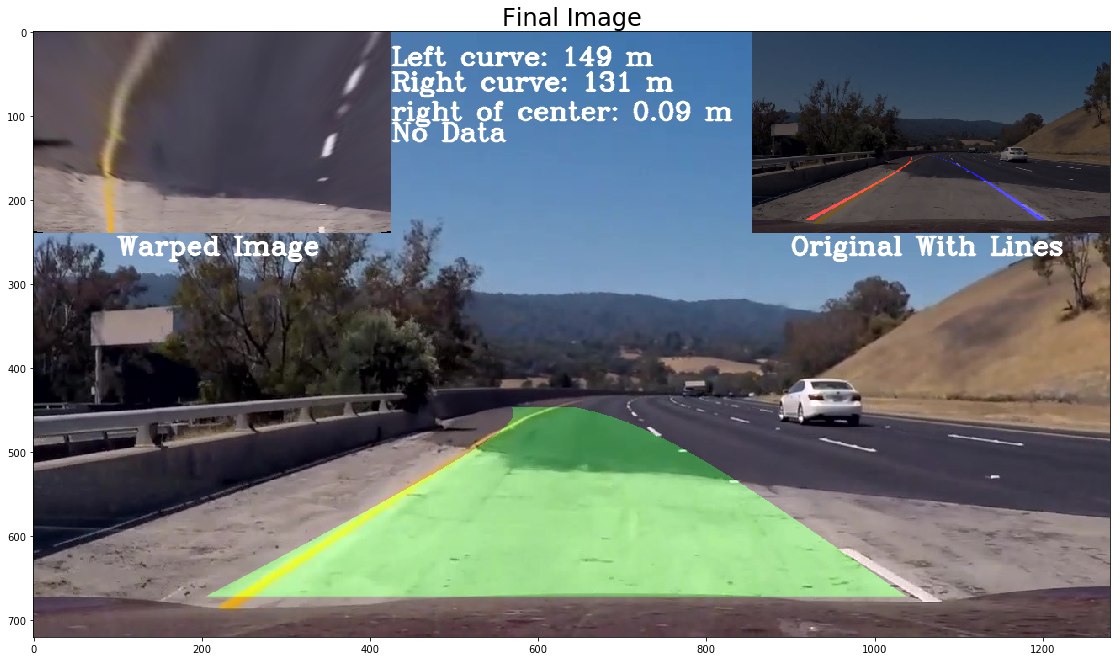

In [18]:
image = mpimg.imread("trimmed2_Moment(2).jpg")


result= RunPipeline(image)
f, (ax1) = plt.subplots(1, 1, figsize=(24, 9))
f.tight_layout()

ax1.imshow(result)
ax1.set_title('Final Image', fontsize=24)

In [19]:
    output = 'test_out.mp4'
    clip1 = VideoFileClip("project_video.mp4")
    clip = clip1.fl_image(RunPipeline) #NOTE: this function expects color images!!
    %time clip.write_videofile(output, audio=False)
    HTML("""
    <video width="960" height="540" controls>
      <source src="{0}">
    </video>
    """.format(output))

[MoviePy] >>>> Building video test_out.mp4
[MoviePy] Writing video test_out.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [04:38<00:00,  4.72it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_out.mp4 

Wall time: 4min 41s


In [ ]:
blarg = []
blarg.append([1,2,3])
print(blarg)
blarg.append([4,5,6])
print(blarg)
blarg.append([7,8,9])
print(blarg[0])

## Visualization of parameters and images

In [ ]:
testImage = mpimg.imread("trimmed_moment(2).jpg")
# Plot the result
f, (ax1) = plt.subplots(1, 1, figsize=(24, 9))
f.tight_layout()

ax1.imshow(testImage)
ax1.set_title('Original Image', fontsize=24)

In [ ]:
# Visualize a sample of the undistorted images
undistortedImages = []
names=[]
images = glob.glob("camera_cal/calibration*.jpg")
calCheck = Path("./calibration_pickle.p")
if calCheck.is_file():
    print("Found Pickle File")
    dist_pickle = pickle.load(open("./calibration_pickle.p", "rb"))
    mtx = dist_pickle["mtx"]
    dist = dist_pickle["dist"]
else: 
    print("No Pickle file found, starting camera calibration")
    mtx, dist = CalibrateCamera((9,6))
for imagePath in images: 
    workingImage = mpimg.imread(imagePath)
    dst = cv2.undistort(workingImage, mtx, dist, None, mtx)
    undistortedImages.append(dst)
    names.append(imagePath)
print(len(undistortedImages))
f, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(24, 9))
f.tight_layout()

ax1.imshow(undistortedImages[0])
ax1.set_title(names[0], fontsize=18)

ax2.imshow(undistortedImages[5])
ax2.set_title(names[5], fontsize=18)

ax3.imshow(undistortedImages[17])
ax3.set_title(names[17], fontsize=18)

ax4.imshow(undistortedImages[19])
ax4.set_title(names[19], fontsize=18)

plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [ ]:
# visualize the undistorted image
chessboardCount = (9,5)
calCheck = Path("./calibration_pickle.p")
if calCheck.is_file():
    print("Found Pickle File")
    dist_pickle = pickle.load(open("./calibration_pickle.p", "rb"))
    mtx = dist_pickle["mtx"]
    dist = dist_pickle["dist"]
else: 
    print("No Pickle file found, starting camera calibration")
    mtx, dist = CalibrateCamera((9,6))
undistortedImageTest = Undistort(testImage, mtx, dist )

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4.5))
f.tight_layout()

ax1.imshow(testImage)
ax1.set_title("Original Image", fontsize=24)

ax2.imshow(undistortedImageTest)
ax2.set_title("Undistorted Image", fontsize=24)

In [ ]:

img_size = (undistortedImageTest.shape[1], undistortedImageTest.shape[0])   
m, Minv = GetWarpImageData(img_size)

f, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(24,9))
f.tight_layout()

ax1.imshow(undistortedImageTest)
ax1.set_title("Original", fontsize=24)
ax1.plot(588, 446,'X')
ax1.plot(691, 446,'X')
ax1.plot(153, 673,'X')
ax1.plot(1126, 673,'X')


warpedTest = cv2.warpPerspective(undistortedImageTest, m, img_size, flags=cv2.INTER_LINEAR) 
ax2.imshow(warpedTest)
ax2.set_title("Warped", fontsize=24)
ax2.plot(320, 0,'X')
ax2.plot(960, 0,'X')
ax2.plot(320, 720,'X')
ax2.plot(960, 720,'X')

unWarp = cv2.warpPerspective(warpedTest, Minv, img_size, flags=cv2.INTER_LINEAR) 
ax3.imshow(unWarp)
ax3.set_title("UnWarped", fontsize=24)

plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [ ]:
#Visualize a processed binary image
#convert the image to HLS, and use the S channel.
hlsImage = cv2.cvtColor(warpedTest,cv2.COLOR_RGB2HLS)
S = hlsImage[:,:,2]
combinedTest = ProcessImage(S)
plt.imshow(combinedTest, cmap ='gray')

Histogram of the lines in the road. 

In [ ]:
histogram = np.sum(combinedTest[combinedTest.shape[0]/2:,:], axis=0)
plt.plot(histogram)

In [ ]:
print(combinedTest.shape)
print(warpedTest.shape)

leftx, rightx, lefty, righty, left_fit, right_fit, left_fitx, right_fitx = FindLinesInIntialImage(combinedTest)





In [ ]:
# Fit a second order polynomial to pixel positions in each  lane line
# Plot up the data
ploty = np.linspace(0, combinedTest.shape[0]-1, combinedTest.shape[0] )
mark_size = 3
#print(left_fitx.shape)
#print(lefty.shape)
plt.plot(leftx, lefty, 'o', color='red', markersize=mark_size)
plt.plot(rightx, righty, 'o', color='blue', markersize=mark_size)
plt.xlim(0, 1280)
plt.ylim(0, 720)
plt.plot(left_fitx, ploty, color='green', linewidth=3)
plt.plot(right_fitx, ploty, color='green', linewidth=3)
plt.gca().invert_yaxis() # to visualize as we do the images

In [ ]:
# display a test of the above method
left_curverad,right_curverad, center = DetermineCurve(left_fit, right_fit, leftx, rightx, lefty, righty, ploty)
# left_curverad,right_curverad, center = curvature(left_fit, right_fit, ploty)
print("left: ", left_curverad, 'm')
print("right: ", right_curverad, 'm')

In [ ]:
regionTest = DrawRegion(testImage, combinedTest, left_fitx, right_fitx, ploty, Minv)
plt.imshow(regionTest)

In [ ]:
# test the sanity check
leftOld = 1121.78640372  
leftx, rightx, lefty, righty, left_fit, right_fit, left_fitx, right_fitx = FindLinesInIntialImage(combinedTest)
left_curve, right_curve, center = DetermineCurve(left_fit, right_fit, leftx, rightx, lefty, righty, ploty)
result = DeterimeIfSimilar(leftOld, left_curve)
print(result, left_curve)

In [ ]:
## OLD!!!!!!!!!!!!!!!!!!


# used to hold a collection so we can average it out
global leftCurveCollection
global rightCurveCollection
leftCurveCollection = []
rightCurveCollection = []
global lastOffLeft
global lastOffRight
lastOffLeft = 0
lastOffRight = 0
def RunPipeline(image):
    global count
    global left_fit
    global right_fit
    #print(count)
    img_size = (image.shape[1], image.shape[0]) 
    # undistort the image using the calibrated values
    undistortedImage = Undistort(image, mtx, dist )
    m, Minv = GetWarpImageData(img_size)
    # warp the image into an overhead view
    warped = cv2.warpPerspective(undistortedImage, m, img_size, flags=cv2.INTER_LINEAR) 
    # work with the S channel
    hlsImage = cv2.cvtColor(warped,cv2.COLOR_RGB2HLS)
    S = hlsImage[:,:,2]
    
    # perform the gradient and threshold work and get a binary image
    combined = ProcessImage(S)
    leftx, rightx, lefty, righty, left_fit, right_fit, left_fitx, right_fitx, outImg = FindLinesInIntialImage(combined)
    #if this is the first image through, then we are on the first image.
    """
    if count < 1:
        print("firstImage")
        leftx, rightx, lefty, righty, left_fit, right_fit, left_fitx, right_fitx = FindLinesInIntialImage(combined)
    else:
        leftx, rightx, lefty, righty, left_fit, right_fit, left_fitx, right_fitx = ProcessSubsequantImages(combined, left_fit, right_fit)
        # this will smooth out the lines over the last 5 frames
   """
    ploty = np.linspace(0, combined.shape[0]-1, combined.shape[0] )     
    
    # Deterimne the radius of the curve
    left_curve, right_curve, center = DetermineCurve(left_fit, right_fit, leftx, rightx, lefty, righty, ploty)
      
    left_curve, right_curve, similar = SmoothLines(left_curve, right_curve,leftx, rightx) 

    # Tell how far left or right of center the vehicle is
    if center > 0:
        center = "left of center: " + str(np.abs(center))
    else: 
        center = "right of center: " + str(np.abs(center))
        
    # Draw the region on the image.
    finalImage = DrawRegion(image, combined, left_fitx, right_fitx, ploty, Minv)
    finalImage = AnnotateImage(finalImage, left_curve, right_curve, center, warped, combined, similar)
    count +=1
    return finalImage, outImg
    #plt.imshow(finalImage, cmap='gray')
    #print(left_curve, right_curve, center, count)


In [ ]:
#takes an average over the last 5 frames and determines an average so the lines are smoother

def SmoothLines_old(leftFitX, rightFitX):    
    # Perform the sanity check
    leftAverage = leftFitX
    rightAverage = rightFitX
    """    
    left_fitAverage = left_fit
    right_fitAverage = right_fit
    leftxAverage = leftx
    rightxAverage = rightx
    leftyAverage  = lefty
    rightyAverage  =righty
    plotyAverage =ploty
    """
    similar = len(leftFitXCollection) 
    if len(leftFitXCollection) > 1:
        smiliar = 'Coll > 1'
        if DetermineIfSimilar(leftFitXCollection[len(leftFitXCollection) - 1]):
            smiliar = 'yes'
            # if the collection has more than 10 entries, we want to remove the first one [0]
            if len(leftFitXCollection) >= 5:
                #print("over 5... removing")
                lastLeft = leftFitXCollection[0]
                lastRight = rightFitXCollection[0]
                leftFitXCollection.remove(lastLeft)
                rightFitXCollection.remove(lastRight)  
    #append the new value and 
    leftFitXCollection.append(leftFitX)
    rightFitXCollection.append(rightFitX)
    leftAverage = sum(leftFitXCollection)/len(leftFitXCollection)
    rightAverage = sum(rightFitXCollection)/len(rightFitXCollection)
    return leftAverage, rightAverage, similar

In [ ]:

window_centroids = find_window_centroids(combinedTest, window_width, window_height, margin)

# Below is just used for visualization, dont need this in prod code really

# This will draw lines for the curves
leftx = []
rightx = []
for level in range(0,len(window_centroids)):
    leftx.append(window_centroids[level][0])
    rightx.append(window_centroids[level][1])
combined = combinedTest
yvals = range(0, combined.shape[0])

res_yvals = np.arange(combined.shape[0]-(window_height/2),0,-window_height)

left_fit = np.polyfit(res_yvals, leftx, 2)
left_fitx = left_fit[0]*yvals*yvals + left_fit[1]*yvals + left_fit[2]
left_fitx = np.array(left_fitx, np.int32)

right_fit = np.polyfit(res_yvals, rightx, 2)
right_fitx = right_fit[0]*yvals*yvals + right_fit[1]*yvals + right_fit[2]
right_fitx = np.array(right_fitx, np.int32)
    
left_lane = np.array(list(zip(np.concatenate((left_fitx-window_width/2, left_fitx[::-1]+window_width/2), axis=0), np.concatenate((yvals, yvals[::-1]), axis=0))), np.int32)
right_lane = np.array(list(zip(np.concatenate((right_fitx-window_width/2, right_fitx[::-1]+window_width/2), axis=0), np.concatenate((yvals, yvals[::-1]), axis=0))), np.int32)
middle_marker = np.array(list(zip(np.concatenate((right_fitx-window_width/2, right_fitx[::-1]+window_width/2), axis=0), np.concatenate((yvals, yvals[::-1]), axis=0))), np.int32)

image = warpedTest
road = np.zeros_like(image)
road_bkg = np.zeros_like(image)
cv2.fillPoly(road, [left_lane], color=[255,0,0])
cv2.fillPoly(road, [right_lane], color=[0,0,255])
cv2.fillPoly(road_bkg, [left_lane], color=[255,255,255])
cv2.fillPoly(road_bkg, [right_lane], color=[255,255,255])
result = road

#this will draw the centeroids on the image

if len(window_centroids) > 0:

    # Points used to draw all the left and right windows
    l_points = np.zeros_like(combinedTest)
    r_points = np.zeros_like(combinedTest)

    # Go through each level and draw the windows 	
    for level in range(0,len(window_centroids)):       
        #leftx.append(window_centroids[level][0])
        #rightx.append(window_centroids[level][1])
        # Window_mask is a function to draw window areas
        l_mask = window_mask(window_width,window_height,combinedTest,window_centroids[level][0],level)
        r_mask = window_mask(window_width,window_height,combinedTest,window_centroids[level][1],level)
        # Add graphic points from window mask here to total pixels found 
        l_points[(l_points == 255) | ((l_mask == 1) ) ] = 255
        r_points[(r_points == 255) | ((r_mask == 1) ) ] = 255

    # Draw the results
    template = np.array(r_points+l_points,np.uint8) # add both left and right window pixels together
    zero_channel = np.zeros_like(template) # create a zero color channle 
    template = np.array(cv2.merge((zero_channel,template,zero_channel)),np.uint8) # make window pixels green
    warpage = np.array(cv2.merge((combinedTest,combinedTest,combinedTest)),np.uint8) # making the original road pixels 3 color channels
    output = cv2.addWeighted(warpage, 1, template, 1.0, 0.0) # overlay the orignal road image with window results
 
# If no window centers found, just display orginal road image
else:
    output = np.array(cv2.merge((warped,warped,warped)),np.uint8)
    
output = cv2.warpPerspective(result, Minv, img_size, flags=cv2.INTER_LINEAR)
output = cv2.addWeighted(output, 1, testImage, 0.5, 0.0)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4.5))
f.tight_layout()

ax1.imshow(combinedTest, cmap="gray")
ax1.set_title("Original Image", fontsize=24)

ax2.imshow(output)
ax2.set_title("Windows Centroids", fontsize=24)

In [ ]:
def DetermineCurve_old(left_fit, right_fit, leftx, rightx, lefty, righty, ploty):
    ploty = np.linspace(0, 719, 720)
    y_eval = np.max(ploty)
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension   
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    #print(left_curverad, 'm', right_curverad, 'm')
    center = (((left_fit[0]*720**2+left_fit[1]*720+left_fit[2]) +(right_fit[0]*720**2+right_fit[1]*720+right_fit[2]) ) /2 - 640)*xm_per_pix
    center = round(center, 2)
    return left_curverad,right_curverad, center

In [ ]:
def FindLinesInIntialImage(img):
    binary_warped = img

    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]/2:,:], axis=0)
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        print("iterating Windows")
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    #visualization of the image
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    return leftx, rightx, lefty, righty, left_fit, right_fit, left_fitx, right_fitx, out_img



In [ ]:
def ProcessSubsequantImages(binary_warped, left_fit, right_fit ):
    # Assume you now have a new warped binary image 
    # from the next frame of video (also called "binary_warped")
    # It's now much easier to find line pixels!
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return leftx, rightx, lefty, righty, left_fit, right_fit, left_fitx, right_fitx


